# Histogram of Oriented Gradients (HOG) with CIFAR10 Dataset with `pytorch`

In [210]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision import transforms
from skimage.feature import hog
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import random

In [211]:
def apply_hog(img, o = 9, ppc = (4, 4), cpb = (2, 2), show_image = False):
    # apply HOG to image
    img = img.squeeze() # remove channel dimension
    if show_image:
        features, hog_image = hog(
            img,
            orientations = o,
            pixels_per_cell = ppc,
            cells_per_block = cpb,
            visualize = True,
            channel_axis = -1
        )

        return features, hog_image
    else:
        features = hog(
            img,
            orientations = o,
            pixels_per_cell = ppc,
            cells_per_block = cpb,
        )
        
        return features

In [212]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The CIFAR10 and CIFAR100 datasets have 10 and 100 classes respectively. The `CIFAR10` class loads in the data. Additionally, we extract HOG features directly when we load the data with `transforms`.
- Train set size: 50000
- Test set size: 10000

Additionally, the `CIFAR10` dataset has these classes: `airplane`, `automobile`, `bird`, `cat`, `deer`, `dog`, `frog`, `horse`, `ship`, and `truck`.

All **original** images have size $32\times32\times3$ pixels (3 color channels).

In [213]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels = 1),
    transforms.Lambda(apply_hog)
])

cifar_train = CIFAR10("./data_cifar10/", download = True, transform = transform)
cifar_test = CIFAR10("./data_cifar10/", train = False, download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


(1764,)


C:\Users\fongc\AppData\Local\Temp\ipykernel_14820\4120800861.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


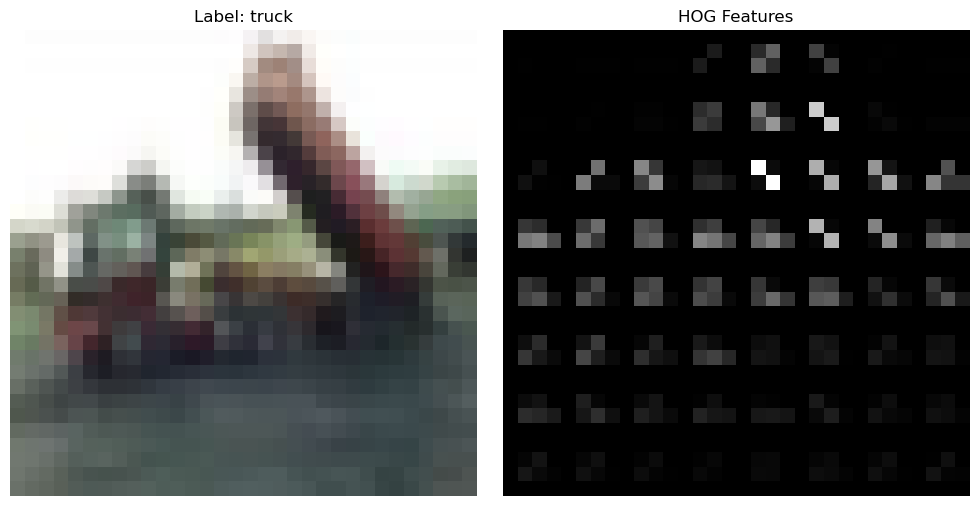

In [214]:
# sample image
sample_image = cifar_train.data[2, :, :]
sample_target = cifar_train.targets[2]

idx_class = { v : k for k, v in cifar_test.class_to_idx.items() }
sample_label = idx_class[sample_target]

# show image
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].imshow(sample_image)
axes[0].axis("off")
axes[0].set_title("Label: {}".format(sample_label))

sample_features, sample_hog_image = apply_hog(sample_image,show_image = True)

axes[1].imshow(sample_hog_image, cmap = "gray")
axes[1].axis("off")
axes[1].set_title("HOG Features")

fig.tight_layout()
fig.show()

print(sample_features.shape)

In [215]:
# sample features
print(cifar_train[0][0].shape)

(1764,)


In [216]:
# define linear model
model = nn.Linear(1764, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [217]:
# initialize data loader
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = BATCH_SIZE, shuffle = False)

In [218]:
# test iterations
counter = 0
for it in range(1):
    for features, labels in train_loader:
        if counter >= 1:
            break
        print("Shape:", features.shape, labels.shape)
        print("First Label:", idx_class[labels[0].item()])

        counter += 1

Shape: torch.Size([128, 1764]) torch.Size([128])
First Label: deer


In [219]:
# train model
losses = []
num_epochs = 8
for it in range(num_epochs):
    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()
        optimizer.zero_grad()

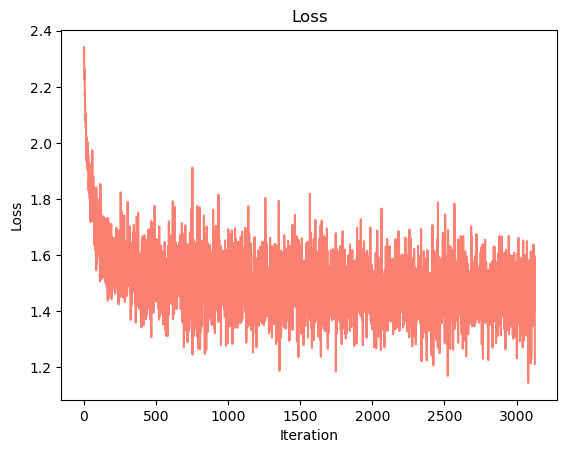

In [ ]:
# plot loss
plt.plot(losses, c = "salmon")
plt.title("Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

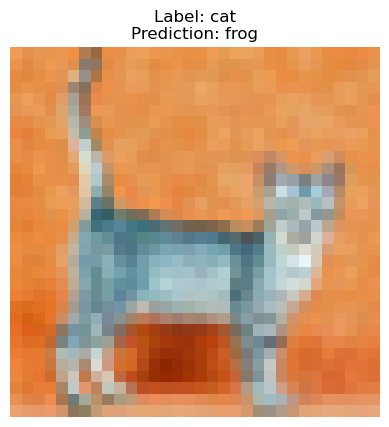

In [ ]:
# make sample prediction
idx = random.randint(0, len(cifar_test.data))

sample_image = cifar_test.data[idx, :, :]
sample_target = idx_class[cifar_test.targets[idx]]
prediction = idx_class[np.argmax(model(torch.tensor(cifar_test[idx][0]).to(device)).cpu().detach().numpy())]

# show image
plt.imshow(sample_image)
plt.axis("off")
plt.title("Label: {}\nPrediction: {}".format(sample_target, prediction))
plt.show()

In [ ]:
# make predictions on test set
predictions = []
for features, labels in test_loader:
    features = features.to(device)
    labels = labels.to(device)

    outputs = model(features)
    predictions.extend(np.argmax(outputs.cpu().detach().numpy(), axis = 1))

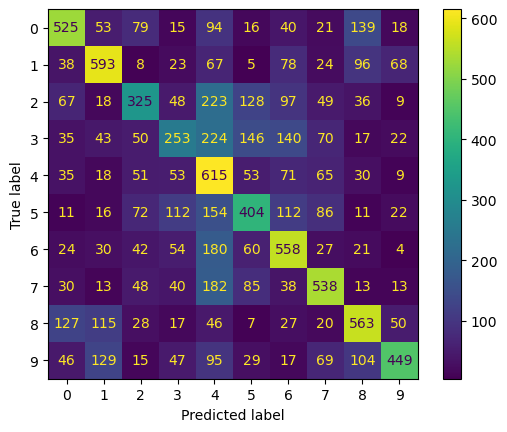

In [ ]:
# construct confusion matrix
matrix = metrics.ConfusionMatrixDisplay.from_predictions(cifar_test.targets, predictions)

In [ ]:
accuracy = metrics.accuracy_score(cifar_test.targets, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.4823
